<a href="https://colab.research.google.com/github/levizwannah/drunk-detection-QCNN/blob/main/Sober_Drunk_Q_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dsName = 'finalDataset'
testDsName = 'testDataset'

Information on the Dataset
***********************************************************

                SOBER  -  DRUNK   DATA BASE

(Started September 2012    ----   Completed April 2013)

Electronics Laboratory - Physics Department
University of Patras  -  Greece

By Georgia Koukiou and Vassilis Anastassopoulos
gkoukiou@upatras.gr      vassilis@upatras.gr 

Every body can use this data base testing and publishing 
experimental results, provided that she/he will refer to 
relevant publications of the creators of this database. 

***********************************************************  
**The Dataset**  
It contains data for 41 persons.
For each person there are 16 different acquisitions
Each acquisition corresponds to each file of the data base
Each file contains 50 sequential frames of the same object 
acquired every 100msec, i.e. in 5 sec all 50 frames.  

**Infrared image acquisition**

Time 20:50
Firstly, for each sober person, which is in calm condition,
an infrared sequence (1) is obtained from his Face (f), from 
his Eyes (e), from his Ear-profile (r), and his Hand (h).

> 21:00 - 22:00
After that four glasses of wine are drunk in one hour time.

> 22:20
A new sequence (2) of infrared images is acquired 
    (f), (e), (r), (h).

> 22:50
A new sequence (3) of infrared images is acquired 
    (f), (e), (r), (h).

> 23:20
A new sequence (4) of infrared images is acquired 
    (f), (e), (r), (h).

We had the people in groups of 4 or 5 or 6 persons. 
For two groups (10 people) we asked the police to carry 
out measurement with alcohol-meter. 
We have the correspondence of these measurements 
with the persons. 

***********************************************************

Naming the files
serialnumber_personfirstname_acquisitionsequence_imagecontent
_sex_age_weight__alcoholmeter

The two last measurements were obtained from few persons

***********************************************************
Image Dimension: 160 x 128

**DATA Preparation**  
First extract the frames from the TIF Files and save them individually after converting them to JPEG. The frames in the TIF Files have 4 color channels, RGBA, however, since JPEG cannot handle 4 color channels, we convert the color to RGB.

In [ ]:
from zmq.constants import Errno
import os
from PIL import Image

basePath = "/content/drive/MyDrive/isp2Data"
path = f"{basePath}/combined"
newDir = f"{basePath}/{dsName}"
drunkPath = f"{newDir}/drunk"
soberPath= f"{newDir}/sober"

# separating from test dataset
testPath = f"{basePath}/{testDsName}";
testDrunk = f"{testPath}/drunk"
testSober = f"{testPath}/sober"

if not os.path.isdir(newDir):
  os.mkdir(newDir)

if not os.path.isdir(drunkPath):
  os.mkdir(drunkPath)

if not os.path.isdir(soberPath):
  os.mkdir(soberPath)

if not os.path.isdir(testPath):
  os.mkdir(testPath)

if not os.path.isdir(testSober):
  os.mkdir(testSober)

if not os.path.isdir(testDrunk):
  os.mkdir(testDrunk)

lsdir = os.listdir(path)


testSize = 2438;
counter = 0;

for f in lsdir:  
    file, ext = os.path.splitext(f)
    labelInfo = file.split('_')

    # only allow eye and face in the dataset
    if(labelInfo[3] == 'r' or labelInfo[3] == 'h'):
      continue

    if(counter < testSize):
      labelFolder = testSober if(labelInfo[2] == '1') else testDrunk;
      label = 'sober' if (labelFolder == testSober) else 'drunk';
    else:
      labelFolder = soberPath if(labelInfo[2] == '1') else drunkPath
      label = 'sober' if (labelFolder == soberPath) else 'drunk'

    bn = os.path.join(labelFolder, file)
    
    imgpath = os.path.join(path, f)
    try: 
      img = Image.open(imgpath)
      for i in range(50):
          try:
              img.seek(i)
              out = img.convert("RGB")
              out.save(f'{bn}_frame_{i}_{label}.jpeg', "JPEG", quality=100)
              counter += 1;
          except EOFError:
              break
    except Exception:
      continue

**Loading and Preprocessing the data**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
import glob
dataDir = f"/content/drive/MyDrive/isp2Data/{dsName}"
allImages = glob.glob(f"{dataDir}/*/*.jpeg")
print("There are " + str(len(allImages)) + " JPEG Images in the main dataset")

There are 13800 JPEG Images in the main dataset


In [ ]:
def plotImageFromDs(subDir, label, count):

  dataDir = f"/content/drive/MyDrive/isp2Data/{dsName}"
  i = 0
  counter = 1;
  plt.figure(figsize=(10, 10))
  for filename in os.listdir(f"{dataDir}/{subDir}"):
    i += 1

    if(i % 50 != 0):
      continue

    img = PIL.Image.open(dataDir + f"/{subDir}/" + filename)
    ax = plt.subplot(3, 3, counter)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

    if(counter == count): break

    counter += 1

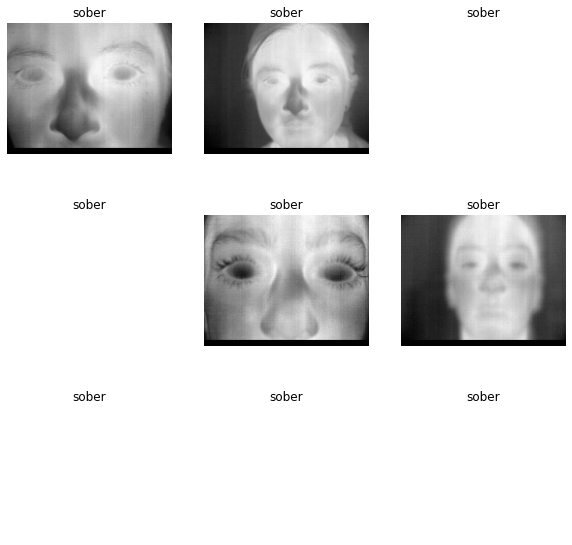

In [ ]:
# sober Images
plotImageFromDs("sober", "sober", 9)

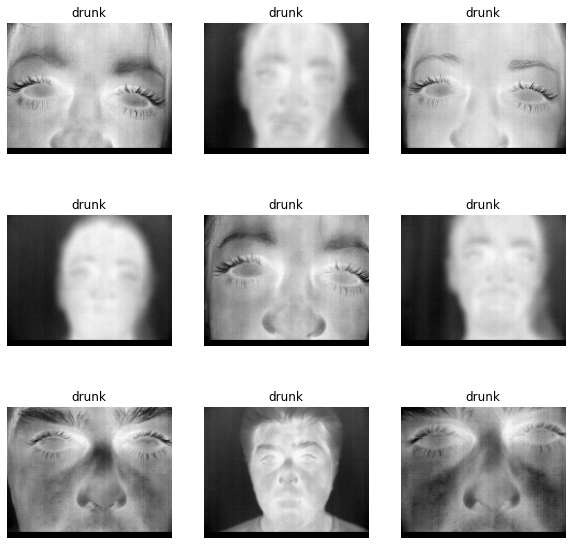

In [ ]:
# drunk images
plotImageFromDs("drunk", "drunk", 9)

**Configuring the dataset for usage**

In [ ]:
# convert all image to jpeg


Set the parameters for the QCNN training.  
The image dimensions is 128 x 160.

In [ ]:
batchSize = 32
imgHeight = 128
imgWidth = 160
dataDir = f"/content/drive/MyDrive/isp2Data/{dsName}"
testDir = f"/content/drive/MyDrive/isp2Data/{testDsName}"

In [ ]:
# training dataset  
trainDs = tf.keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split = 0.15,
    subset = "training",
    seed = 123,
    image_size = (imgHeight, imgWidth),
    batch_size = batchSize
)

Found 13800 files belonging to 2 classes.
Using 11730 files for training.


In [ ]:
# validation dataset
valDs = tf.keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split = 0.15,
    subset = "validation",
    seed = 123,
    image_size = (imgHeight, imgWidth),
    batch_size = batchSize
)

Found 13800 files belonging to 2 classes.
Using 2070 files for validation.


* The test dataset is from its own directory hence has not been seen before by the model. And it is not augmented.

In [ ]:
testDs = tf.keras.utils.image_dataset_from_directory(
    testDir,
    seed = 123,
    image_size = (imgHeight, imgWidth),
    batch_size = batchSize
)

Found 2450 files belonging to 2 classes.


In [ ]:
# classes
classNames = testDs.class_names
print(classNames)

['drunk', 'sober']


In [ ]:
for imageBatch, labelsBatch in trainDs:
  print(imageBatch.shape)
  print(labelsBatch.shape)
  break

**Data Augmentation**  
We need data augmentation because of the extreme similarity between images
in the dataset. Each frame is 100msec apart. Hence, they look closely the same. Therefore, I created augmented images to create some difference.

In [ ]:
augment = Sequential([
    layers.RandomFlip("horizontal", input_shape=(imgHeight, imgWidth, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


In [ ]:
trainDsAugmented = trainDs.map(lambda x, y: (augment(x, training = True), y ) )
valDsAugmented = valDs.map(lambda x, y: (augment(x, training = True), y ) )

Combine the augmented dataset with the original ones

In [ ]:
trainDs = trainDs.concatenate(trainDsAugmented)
valDs = valDs.concatenate(valDsAugmented)

In [ ]:
def plotImage(dataset, take):
  plt.figure(figsize=(10, 10))
  for images, _ in dataset.take(take):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[0].numpy().astype("uint8"))
      plt.axis("off")

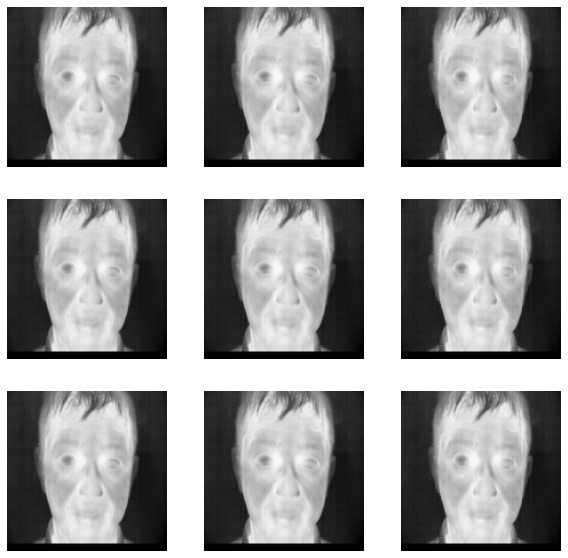

In [ ]:
plotImage(trainDs, 1)

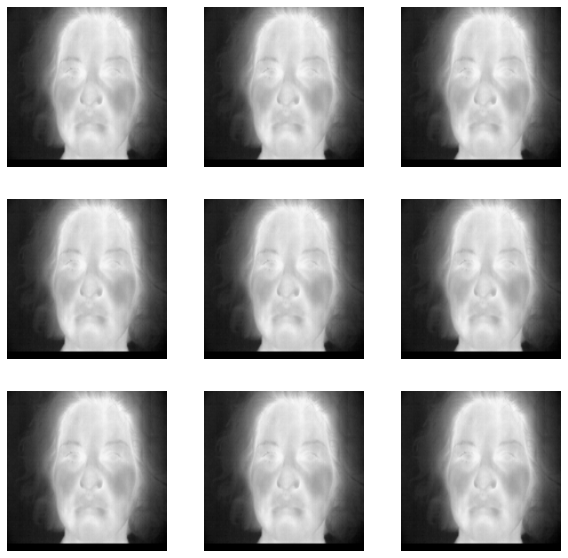

In [ ]:
plotImage(valDs, 1)

**Configuring dataset for performance**

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
trainDs = trainDs.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
valDs = valDs.cache().prefetch(buffer_size = AUTOTUNE)
testDs = testDs.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
class QCNNModel:
  def __init__(self, numOfClasses, imageShape):
    self.model = Sequential(
        [
            layers.Rescaling(1./255, input_shape=imageShape),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(numOfClasses)
        ]
    )

    self.epochs = 5
  
  def compile(self):
    self.model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
  def summary(self):
    self.model.summary()

  def train(self, trainDs, valDs, numOfEpochs):
    self.epochs = numOfEpochs
    self.history = self.model.fit(
        trainDs,
        validation_data = valDs,
        epochs = numOfEpochs
    )

  def inspect(self):
    history = self.history
    acc = history.history['accuracy']
    valAcc = history.history['val_accuracy']

    loss = history.history['loss']
    valLoss = history.history['val_loss']

    epochsRange = range(self.epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochsRange, acc, label='Training Accuracy')
    plt.plot(epochsRange, valAcc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochsRange, loss, label='Training Loss')
    plt.plot(epochsRange, valLoss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

  def quantize(self):
    converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    self.tfliteModel = converter.convert()
    

  def saveQuantized(self, path):
    # save the model
    with open(f'{path}/model.tflite', 'wb') as f:
      f.write(self.tfliteModel)

  def saveUnquantize(self, path):
    self.model.save(f'{path}/unquantizedCnn')

  def loadUnquantized(self, path):
    self.model = keras.models.load_model(f'{path}/unquantizedCnn')


In [ ]:
qCnn = QCNNModel(len(classNames), (imgHeight, imgWidth, 3))
qCnn.compile()
qCnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 40, 64)        1

**Training the Model**

In [ ]:

modelsPath = "/content/drive/MyDrive/isp2/model"

In [ ]:
epochs = 10
qCnn.train(trainDs, valDs, epochs)
qCnn.saveUnquantize(modelsPath)

Epoch 1/10
734/734 [==============================] - 1730s 913ms/step - loss: 0.4463 - accuracy: 0.7996 - val_loss: 0.2908 - val_accuracy: 0.8787
Epoch 2/10
734/734 [==============================] - 501s 682ms/step - loss: 0.2534 - accuracy: 0.8875 - val_loss: 0.2142 - val_accuracy: 0.8816
Epoch 3/10
734/734 [==============================] - 506s 689ms/step - loss: 0.1879 - accuracy: 0.9124 - val_loss: 0.1893 - val_accuracy: 0.9208
Epoch 4/10
734/734 [==============================] - 496s 676ms/step - loss: 0.1463 - accuracy: 0.9330 - val_loss: 0.1493 - val_accuracy: 0.9343
Epoch 5/10
734/734 [==============================] - 501s 683ms/step - loss: 0.1130 - accuracy: 0.9458 - val_loss: 0.1328 - val_accuracy: 0.9430
Epoch 6/10
734/734 [==============================] - 496s 675ms/step - loss: 0.0956 - accuracy: 0.9540 - val_loss: 0.1275 - val_accuracy: 0.9461
Epoch 7/10
734/734 [==============================] - 499s 680ms/step - loss: 0.0804 - accuracy: 0.9588 - val_loss: 0.1632 

**Inspecting the model**

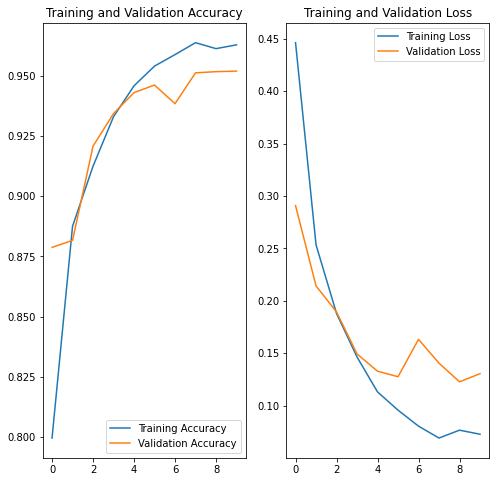

In [ ]:
qCnn.inspect()

In [ ]:
qCnn.loadUnquantized(modelsPath)

**Testing and Evaluation**

In [ ]:
testLoss, testAcc = qCnn.model.evaluate(testDs)
print(testLoss, testAcc)

77/77 [==============================] - 211s 2s/step - loss: 2.4233 - accuracy: 0.7776
2.423272132873535 0.777550995349884


**Quantize the model**  
The quantization is done using Dynamic Range Quantization which quantize the weights from float 32 to int 8 as well as the activations, but during inference.

In [ ]:
# Quantization
qCnn.quantize()
qCnn.saveQuantized(modelsPath)